# Imports

In [1]:
import numpy as np #for handling arrays 
import pandas as pd #for handling dataframes 
# for building models 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
# for hyperparameter tuning 
from sklearn.model_selection import train_test_split, GridSearchCV
# for model evaluation 
from sklearn.metrics import mean_absolute_error, r2_score
# for visualzing results 
import matplotlib.pyplot as plt 
# to interact with hardware and save the final model 
import os
import joblib
# to read data from SQL
import mysql.connector
# use the style available in seaborn library 
plt.style.use('seaborn')

# Constants 

In [2]:
# create some constants 
RESULTS_SAVE_PATH = 'Results/'
MODEL_SAVE_PATH = 'Objects/Models/'
EVALUATION_FIGSIZE = (16,6)
EVALUATION_NROWS = 1
EVALUATION_NCOLS = 2
CITIES = ['AHEMDABAD','BANGALORE','CHENNAI','DELHI','HYDERABAD','KOLKATA','MUMBAI','PUNE']
TEST_SIZE = 0.3
RANDOM_STATE = 42
with open('credentials.txt', 'r') as f:
    PASSWORD = f.read().strip()

# Reading data

In [3]:
# Connect to MySQL
conn = mysql.connector.connect(
    host='34.93.147.30',
    port=3306,
    user='root',
    password=PASSWORD,
    database='PREPROCESS',
    auth_plugin='mysql_native_password'
)
# Fetch the data and store in the dictionary 
df_dict = dict(zip(CITIES, [pd.read_sql(f'SELECT * FROM {city}', con=conn) for city in CITIES]))
# close the connection 
conn.close()
# rename the columns to ensure uniformity
cols = cols = ['SELLER TYPE','BEDROOM','LAYOUT TYPE','PROPERTY TYPE','LOCALITY','PRICE','AREA','FURNISH TYPE','BATHROOM']
for city, df in df_dict.items():
    df.columns = cols

# Preparing data for model

In [4]:
# store X and y for each city in dictionary
X_dict = dict(zip(CITIES,[df.drop(['PRICE'],axis=1) for df in df_dict.values()]))
y_dict = dict(zip(CITIES,[df['PRICE'] for df in df_dict.values()]))

In [5]:
# Create dictionaries for X_train, y_train, X_test and y_test 
X_train_dict = {}
X_test_dict = {}
y_train_dict = {}
y_test_dict = {}

for city in CITIES:
    # Subset X and y for each city
    X = X_dict[city]
    y = y_dict[city]
    # Perform train test split
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=TEST_SIZE, random_state=RANDOM_STATE)
    # Store values in the dictionary for training models
    X_train_dict[city] = X_train
    X_test_dict[city] = X_test
    y_train_dict[city] = y_train
    y_test_dict[city] = y_test

In [6]:
# create a helper function
def summarize_model(model):
    model_r2_train_dict = {} #create a dictionary for r2 score of train set
    model_r2_test_dict = {} #create a dictionary for r2 score of test set
    model_mae_train_dict = {} #create a dictionary for mae of train set 
    model_mae_test_dict = {} #create a dictionary for mae of test set
    model_dict = {} #create a dictionary of models 
    for city in CITIES: #loop through the cities 
        model.fit(X_train_dict[city],y_train_dict[city]) #fit the model 
        model_dict[city] = model #store the model for that city in model dict
        model_train_preds = model.predict(X_train_dict[city]) #predict for train set 
        model_test_preds = model.predict(X_test_dict[city]) #predict for test set 
        model_r2_train_dict[city] = r2_score(y_true=y_train_dict[city], y_pred=model_train_preds) #calculate r2 for train set 
        model_r2_test_dict[city] = r2_score(y_true=y_test_dict[city], y_pred=model_test_preds) #calculate r2 for test set 
        model_mae_train_dict[city] = mean_absolute_error(y_true=y_train_dict[city],y_pred=model_train_preds) #calcaulte mae for train set
        model_mae_test_dict[city] = mean_absolute_error(y_true=y_test_dict[city], y_pred=model_test_preds) #calculate mae for test set 

    # store the metrics in a dictionary 
    metrics_dict = {
        'train r2':model_r2_train_dict,
        'test r2':model_r2_test_dict,
        'train mae':model_mae_train_dict,
        'test mae':model_mae_test_dict
    }
    display(pd.DataFrame(metrics_dict))
    return model_dict, metrics_dict #return model and metrics 

In [7]:
# Linear Regression 
lr_dict, lr_metrics = summarize_model(LinearRegression())

,train r2,test r2,train mae,test mae
AHEMDABAD,0.576484,0.572412,4228.388644,4335.716263
BANGALORE,0.637631,0.651159,3941.509990,3904.789345
CHENNAI,0.633526,0.636981,4116.165647,4116.455493
DELHI,0.719554,0.718038,21842.649543,22155.480988
HYDERABAD,0.666592,0.657554,3515.501828,3497.878498
KOLKATA,0.636213,0.637063,3852.781894,3806.310295
MUMBAI,0.437768,0.436943,11819.229907,11952.873775
PUNE,0.607654,0.602247,3452.020474,3435.796273


In [8]:
# Decision tree regression 
dt_dict, dt_metrics = summarize_model(DecisionTreeRegressor())

,train r2,test r2,train mae,test mae
AHEMDABAD,0.970002,0.534985,592.460513,3995.440281
BANGALORE,0.975796,0.524738,486.066014,4274.144471
CHENNAI,0.991441,0.449509,221.401059,4575.522235
DELHI,0.984221,0.835143,2614.805035,12796.479691
HYDERABAD,0.982736,0.511964,339.458933,3925.417186
KOLKATA,0.985162,0.559153,328.322697,3921.851520
MUMBAI,0.966515,0.727109,1627.022118,6712.277104
PUNE,0.963328,0.579960,560.150236,3384.162284


In [9]:
# Random forest regression  
rf_dict, rf_metrics = summarize_model(RandomForestRegressor())

,train r2,test r2,train mae,test mae
AHEMDABAD,0.937600,0.707537,1477.460558,3301.664549
BANGALORE,0.939622,0.709532,1515.972116,3471.083627
CHENNAI,0.951237,0.673768,1405.351115,3612.896765
DELHI,0.972337,0.894451,5220.061973,10744.028542
HYDERABAD,0.947787,0.703999,1301.490782,3067.679817
KOLKATA,0.943091,0.705187,1438.440363,3299.503931
MUMBAI,0.947093,0.805167,2999.729566,5928.391851
PUNE,0.933038,0.695855,1311.843014,2897.307450


In [10]:
# Adaboost Regression
adaboost_dict, adaboost_metrics = summarize_model(AdaBoostRegressor())

,train r2,test r2,train mae,test mae
AHEMDABAD,0.549170,0.535264,4645.687619,4780.643932
BANGALORE,0.574544,0.581230,4566.162816,4511.549933
CHENNAI,0.599012,0.586834,4606.981153,4678.096649
DELHI,0.807470,0.808884,16398.094995,16932.736264
HYDERABAD,0.633773,0.615513,3883.447777,3874.591516
KOLKATA,0.584833,0.568663,4484.070852,4499.829048
MUMBAI,0.332979,0.340950,13950.646378,14018.591446
PUNE,0.530129,0.510356,4071.603188,4093.388063


In [11]:
# Gradient boosting regression 
gb_dict, gb_metrics = summarize_model(GradientBoostingRegressor())

,train r2,test r2,train mae,test mae
AHEMDABAD,0.753599,0.724288,3120.459677,3312.193167
BANGALORE,0.728988,0.727835,3390.293014,3424.249640
CHENNAI,0.754321,0.718966,3259.847268,3476.780016
DELHI,0.888856,0.885683,11411.916630,11803.923426
HYDERABAD,0.765201,0.717994,2903.159116,3057.066091
KOLKATA,0.750896,0.722372,3098.940022,3245.348810
MUMBAI,0.719642,0.712283,7900.784804,8007.224594
PUNE,0.743454,0.707597,2745.689778,2875.087795


In [12]:
# XGBoost Regression 
xgb_dict, xgb_metrics = summarize_model(XGBRegressor(objective='reg:squarederror'))

,train r2,test r2,train mae,test mae
AHEMDABAD,0.900225,0.749781,1952.076510,3036.114263
BANGALORE,0.867182,0.761061,2338.156615,3132.476465
CHENNAI,0.933435,0.744779,1678.883043,3150.511893
DELHI,0.960877,0.912827,7039.342960,9859.126965
HYDERABAD,0.923365,0.727634,1595.127109,2919.463253
KOLKATA,0.915579,0.749597,1765.240253,3021.563405
MUMBAI,0.890106,0.838798,4731.207929,5550.203402
PUNE,0.869894,0.748530,1893.925299,2612.183834


In [13]:
# create dictionaries for visualization 
model_dict = {
    'LR':lr_dict,
    'DT':dt_dict,
    'RF':rf_dict,
    'ADA':adaboost_dict,
    'GB':gb_dict,
    'XGB':xgb_dict
}
model_metrics = {
    'LR':lr_metrics,
    'DT':dt_metrics,
    'RF':rf_metrics,
    'ADA':adaboost_metrics,
    'GB':gb_metrics,
    'XGB':xgb_metrics
}


In [14]:
# Create dictionaries for metrics for all models 
train_r2 = {}
test_r2 = {}
train_mae = {}
test_mae = {}

for model, metrics_dict in model_metrics.items():
    train_r2[model] = metrics_dict['train r2']
    test_r2[model] = metrics_dict['test r2']
    train_mae[model] = metrics_dict['train mae']
    test_mae[model] = metrics_dict['test mae']

In [15]:
# Convert them to dataframes 
train_r2 = pd.DataFrame(train_r2)
test_r2 = pd.DataFrame(test_r2)
train_mae = pd.DataFrame(train_mae)
test_mae = pd.DataFrame(test_mae)

In [16]:
# Change the column names for identification 
train_r2.columns = [col+'_train_r2' for col in train_r2.columns]
test_r2.columns = [col+'_test_r2' for col in test_r2.columns] 
train_mae.columns = [col+'_train_mae' for col in train_mae.columns]
test_mae.columns = [col+'_test_mae' for col in test_mae.columns]

In [17]:
# Create dataframe for plotting r2 score 
plot_r2 = pd.DataFrame()
for c1, c2 in zip(train_r2.columns, test_r2.columns):
    plot_r2[c1] = train_r2[c1]
    plot_r2[c2] = test_r2[c2]

In [18]:
# create dataframe for plotting mae 
plot_mae = pd.DataFrame()
for c1,c2 in zip(train_mae.columns, test_mae.columns):
    plot_mae[c1] = train_mae[c1]
    plot_mae[c2] = test_mae[c2]

In [19]:
# transpose the dataframes for easy plotting 
plot_r2 = plot_r2.T
plot_mae = plot_mae.T

In [20]:
# Reshape cities to plot better 
cities_plot = np.array(CITIES).reshape(4,2)

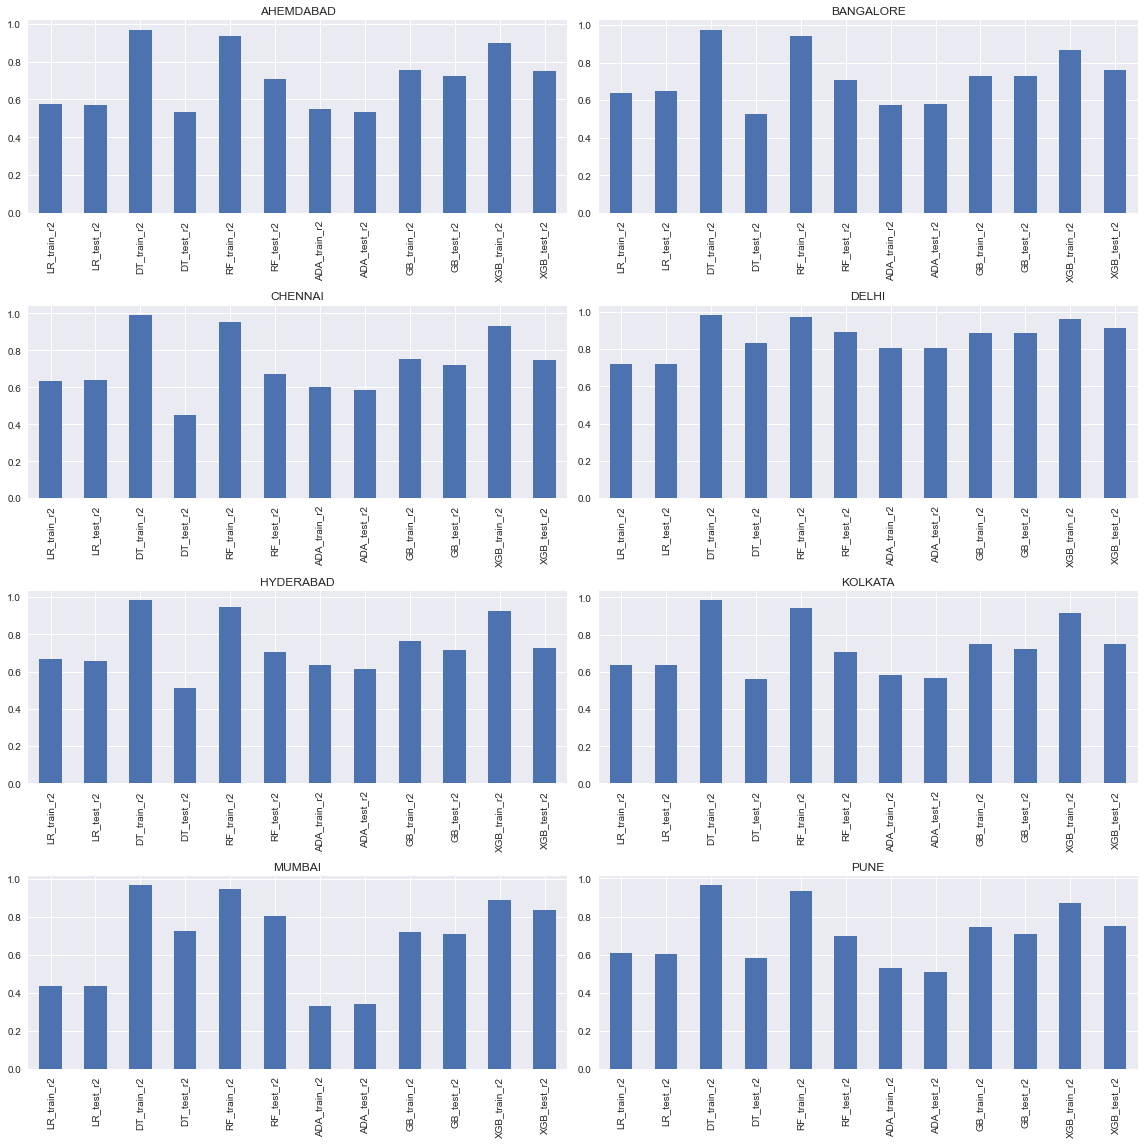

In [21]:
fig, ax = plt.subplots(figsize=(16,16),nrows=4,ncols=2) #create a 4*2 figure 
for i in range(4): #loop through rows 
    for j in range(2): #loop through columns 
        plot_r2[cities_plot[i,j]].plot(kind='bar',ax=ax[i,j]) #plot the column  
        ax[i,j].set_title(cities_plot[i,j]) #set title 
plt.tight_layout() #tight layout for avoiding overlap 
if not os.path.exists(RESULTS_SAVE_PATH): #check if path exists 
    os.makedirs(RESULTS_SAVE_PATH) #if not, create the path 
plt.savefig(os.path.join(RESULTS_SAVE_PATH, 'all_models_r2.png')) #save the results 
plt.show() #show the plot 

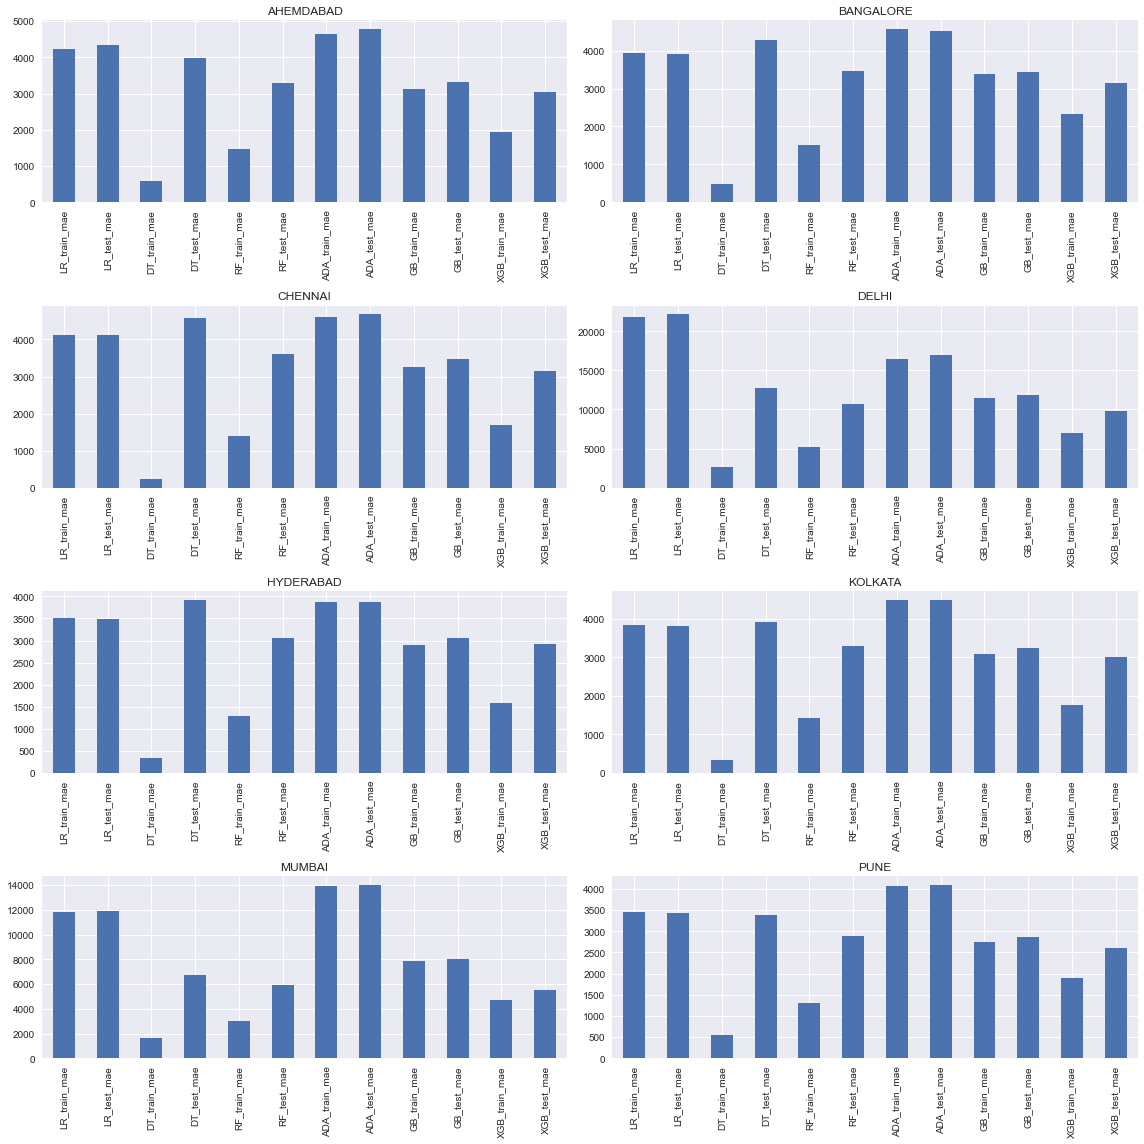

In [22]:
fig, ax = plt.subplots(figsize=(16,16),nrows=4,ncols=2) #create 4*2 figure 
for i in range(4): #loop through rows 
    for j in range(2): #loop through columns 
        plot_mae[cities_plot[i,j]].plot(kind='bar',ax=ax[i,j]) #plot the column 
        ax[i,j].set_title(cities_plot[i,j]) #set the title 
plt.tight_layout() #tight layout to avoud overlap 
plt.savefig(os.path.join(RESULTS_SAVE_PATH, 'all_moedls_mae.png')) #save the figure 
plt.show() #show the figure 

From the above graphs, we can say that XGBRegressor() has the highest r2 score for all the cities and the lowest MAE, hence we will validate the XGBRegressor() model for GridSearchCV()

In [23]:
# hyperparameter tuning 
param_tuning = {
        'learning_rate': [0.001,0.01,0.1],
        'max_depth': [3, 5, 7],
        'n_estimators' : [100, 200,300],
    }

In [24]:
# perform cross validation
xgb_validated_dict = {} #create a dictionary for validated xgboost model 
for city, model in xgb_dict.items(): #loop though  existing xgboost model 
    xgb_validated = GridSearchCV(model, param_tuning, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error') #perform cross validation
    xgb_validated.fit(X_train_dict[city], y_train_dict[city]) #fit the validated model 
    xgb_validated_dict[city] = xgb_validated #save the model in the dictionary 

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [25]:
# create a dictionary for metrics 
xgb_validated_metrics = {}
train_r2_dict = {}
test_r2_dict = {}
train_mae_dict = {}
test_mae_dict = {}
for city, model in xgb_validated_dict.items(): #loop through validated xgboost models 
    train_preds = model.predict(X_train_dict[city]) #predict on train set 
    test_preds = model.predict(X_test_dict[city]) #predict on test set 
    train_r2 = r2_score(y_true=y_train_dict[city],y_pred=train_preds) #calculate r2 on train set 
    test_r2 = r2_score(y_true=y_test_dict[city],y_pred=test_preds) #calculate r2 on test set 
    train_mae = mean_absolute_error(y_true=y_train_dict[city], y_pred=train_preds) #calculate mae on train set 
    test_mae = mean_absolute_error(y_true=y_test_dict[city],y_pred=test_preds) #calculate mae on test set 
    # store metrics in respective dictionaries 
    train_r2_dict[city] = train_r2 
    test_r2_dict[city] = test_r2
    train_mae_dict[city] = train_mae
    test_mae_dict[city] = test_mae
# create dictionary for storing metrics 
xgb_validated_metrics = {
    'train r2':train_r2_dict,
    'test r2':test_r2_dict,
    'train mae': train_mae_dict,
    'test mae':test_mae_dict
}

In [26]:
# convert metrics of xgboost and validated model to dataframe 
xgb_metrics_df = pd.DataFrame(xgb_metrics)
xgb_validated_metrics_df = pd.DataFrame(xgb_validated_metrics)

In [27]:
# rename columns for easy interpretation 
xgb_metrics_df.columns = [col + '_xgb' for col in xgb_metrics_df.columns]
xgb_validated_metrics_df.columns = [col + '_xgb_val' for col in xgb_validated_metrics_df.columns]

In [28]:
# create a final metrics dataframe for plotting 
final_metrics_df = pd.DataFrame()
for c1, c2 in zip(xgb_metrics_df.columns, xgb_validated_metrics_df.columns):
    final_metrics_df[c1] = xgb_metrics_df[c1]
    final_metrics_df[c2] = xgb_validated_metrics_df[c2]

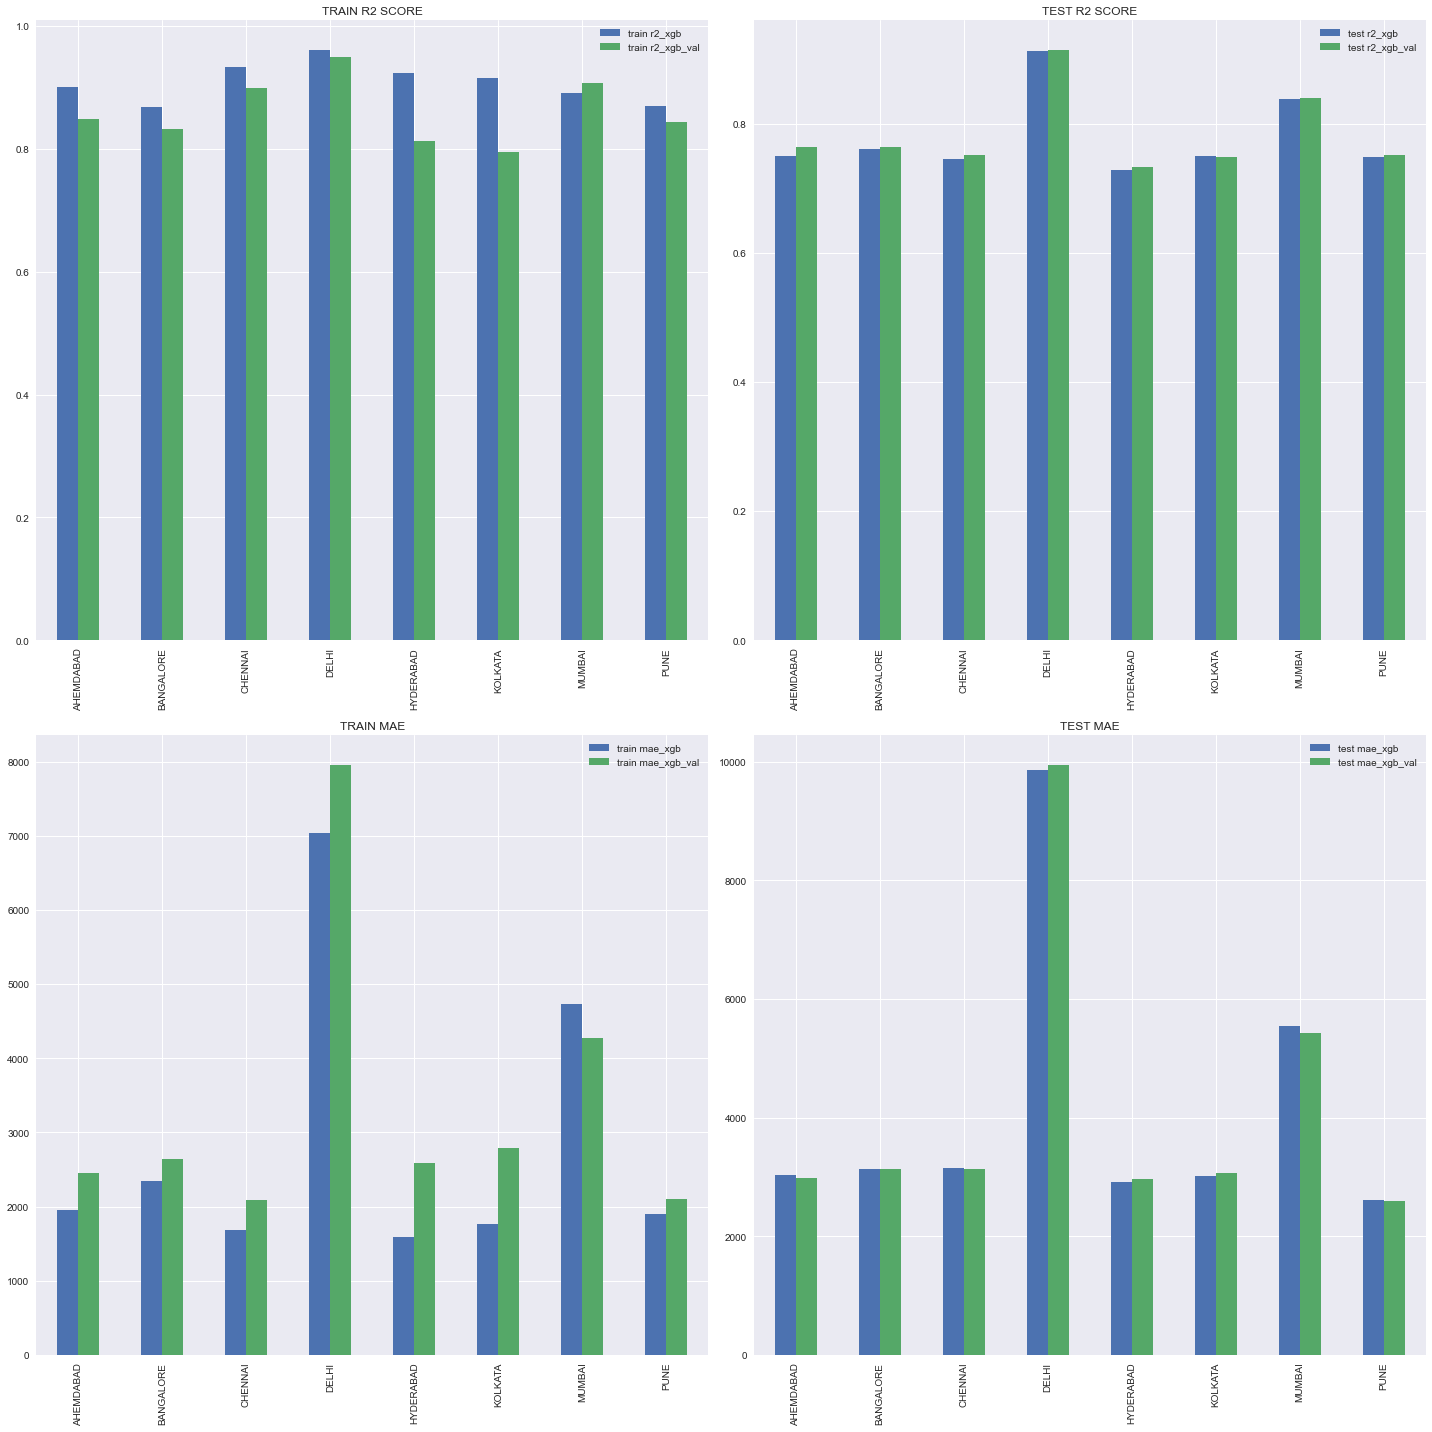

In [29]:
fig, ax = plt.subplots(figsize=(20,20),nrows=2, ncols=2) #create a 2*2 figure 
final_metrics_df[['train r2_xgb', 'train r2_xgb_val']].plot(kind='bar',ax=ax[0,0],title='TRAIN R2 SCORE') #plot train r2 for both models 
final_metrics_df[['test r2_xgb', 'test r2_xgb_val']].plot(kind='bar',ax=ax[0,1], title='TEST R2 SCORE') #plot test r2 for both models 
final_metrics_df[['train mae_xgb', 'train mae_xgb_val']].plot(kind='bar', ax=ax[1,0], title='TRAIN MAE') #plot train mae for both models 
final_metrics_df[['test mae_xgb', 'test mae_xgb_val']].plot(kind='bar', ax=ax[1,1],title='TEST MAE') #plot test mae for both models 
plt.tight_layout() #tight layout to avoid overlap 
plt.savefig(os.path.join(RESULTS_SAVE_PATH, 'hyperparameter_tuning.png')) #save the figure 
plt.show() #show the figure 

Since train and test mae for xgb_validated is higher than xgb for most cities, hence we save xgb model instead of xgb_val

In [30]:
# save the models after fitting them on entire dataset 
for city in CITIES:
    if not os.path.exists(MODEL_SAVE_PATH):
        os.makedirs(MODEL_SAVE_PATH)
    xgb_model = XGBRegressor(objective='reg:squarederror')
    xgb_model.fit(X_dict[city], y_dict[city])
    joblib.dump(xgb_model, os.path.join(MODEL_SAVE_PATH, f'{city}_model.pkl'))